# Investigating CNN Techniques for Image Classification

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Experiment 1: Regularization Techniques

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyperparameters
num_epochs = 25
batch_size = 64
learning_rate = 0.001

In [ ]:
# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [ ]:
# Model
class CNN(nn.Module):
    def __init__(self, use_dropout = False):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.use_dropout = use_dropout

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Experiment 1: Regularization Techniques
regularization_methods = {
    "No Regularization": {"weight_decay": 0, "use_dropout": False},
    "L2 Regularization": {"weight_decay": 1e-4, "use_dropout": False},
    "Dropout Regularization": {"weight_decay": 0, "use_dropout": True}
}

In [ ]:
print("Experiment 1: Regularization Techniques")

batch_loss_logs = {method: [] for method in regularization_methods}
loss_logs = {method: [] for method in regularization_methods}
accuracy_logs = {method: [] for method in regularization_methods}
convergence_threshold = 0.1  # threshold value
converged_epochs = {method: None for method in regularization_methods}



for name, settings in regularization_methods.items():
    print(f"Experimenting with {name}")
    model = CNN(use_dropout=settings["use_dropout"]).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=settings["weight_decay"])

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())
            batch_loss_logs[name].append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Log average loss for this epoch
        average_loss = sum(epoch_losses) / len(epoch_losses)
        loss_logs[name].append(average_loss)

        if average_loss < convergence_threshold and converged_epochs[name] is None:
            converged_epochs[name] = epoch
            print(f"Model with {name} converged at epoch {epoch+1} with loss {average_loss:.4f}")

        # Test the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_accuracy = 100 * correct / total
        accuracy_logs[name].append(epoch_accuracy)

        print(f'Accuracy of the model on the test images: {epoch_accuracy}%')
    print()


Experiment 1: Regularization Techniques
Experimenting with No Regularization
Epoch [1/25], Step [100/782], Loss: 1.7743
Epoch [1/25], Step [200/782], Loss: 1.2378
Epoch [1/25], Step [300/782], Loss: 1.6560
Epoch [1/25], Step [400/782], Loss: 1.1671
Epoch [1/25], Step [500/782], Loss: 1.0569
Epoch [1/25], Step [600/782], Loss: 1.1729
Epoch [1/25], Step [700/782], Loss: 1.1885
Accuracy of the model on the test images: 62.74%
Epoch [2/25], Step [100/782], Loss: 0.8954
Epoch [2/25], Step [200/782], Loss: 0.8021
Epoch [2/25], Step [300/782], Loss: 1.1356
Epoch [2/25], Step [400/782], Loss: 0.6924
Epoch [2/25], Step [500/782], Loss: 0.8159
Epoch [2/25], Step [600/782], Loss: 0.9957
Epoch [2/25], Step [700/782], Loss: 0.7850
Accuracy of the model on the test images: 69.2%
Epoch [3/25], Step [100/782], Loss: 0.7265
Epoch [3/25], Step [200/782], Loss: 0.6564
Epoch [3/25], Step [300/782], Loss: 0.4511
Epoch [3/25], Step [400/782], Loss: 0.7589
Epoch [3/25], Step [500/782], Loss: 0.5615
Epoch [3/

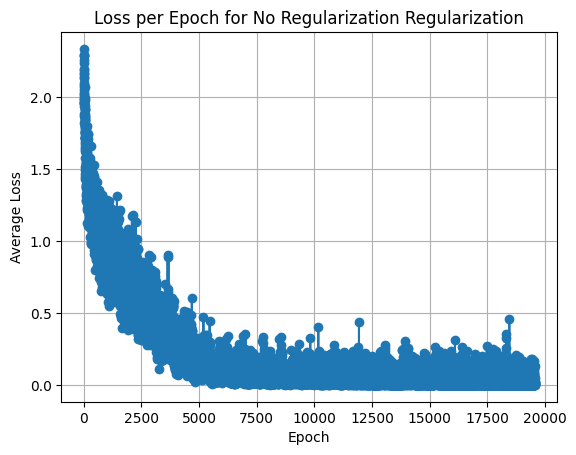

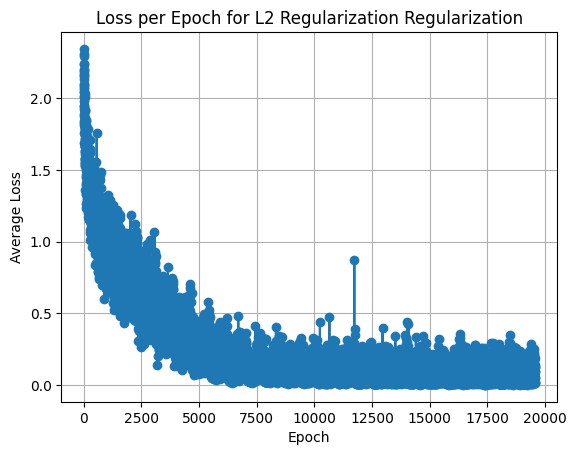

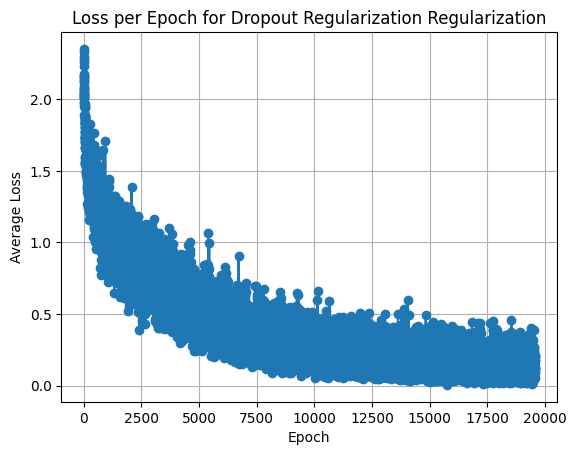

In [ ]:
def plot_loss_curves(loss_logs):
    for method, losses in loss_logs.items():
        if losses:  # Check to make sure there is data to plot
            epochs = range(1, len(losses) + 1)
            plt.plot(epochs, losses, marker='o')
        else:
            print(f"No loss data for {method}.")
        plt.title(f'Loss per Epoch for {method} Regularization')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.grid(True)
        plt.show()


plot_loss_curves(batch_loss_logs)

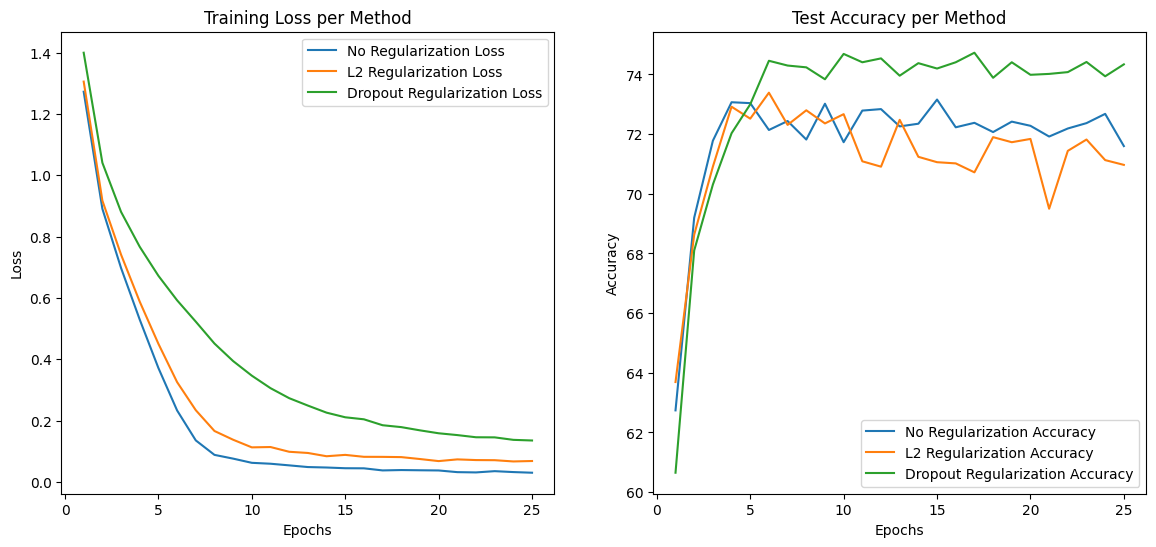

In [ ]:
def plot_learning_curves(loss_logs, accuracy_logs):
    # Create a figure with a specific size
    plt.figure(figsize=(14, 6))

    # Plot training loss per method
    plt.subplot(1, 2, 1)
    for method, losses in loss_logs.items():
        if losses:  # Check if there is data to plot
            epochs = range(1, len(losses) + 1)
            plt.plot(epochs, losses, label=f'{method} Loss')
        else:
            print(f"No data to plot for {method} losses.")
    plt.title('Training Loss per Method')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    for method, accuracies in accuracy_logs.items():
        if accuracies:  # Check if there is data to plot
            epochs = range(1, len(accuracies) + 1)
            plt.plot(epochs, accuracies, label=f'{method} Accuracy')
        else:
            print(f"No data to plot for {method} accuracies.")
    plt.title('Test Accuracy per Method')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plots
    plt.show()

plot_learning_curves(loss_logs, accuracy_logs)


 **Dropout Regularization:** Best generalization, highest stability in test accuracy.

 **L2 Regularization:** Improved stability over no regularization, better generalization.

 **No Regularization:** Volatile test accuracy, potential overfitting.

# Experiment 2: Initialization Techniques

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyperparameters
num_epochs = 25
batch_size = 64
learning_rate = 0.001

In [ ]:
# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Model
class CNN(nn.Module):
    def __init__(self, initialization_method='Default'):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.initialization_method = initialization_method

        # Weight initialization
        if self.initialization_method == 'Kaiming':
            nn.init.kaiming_normal_(self.conv1.weight)
            nn.init.kaiming_normal_(self.conv2.weight)
            nn.init.kaiming_normal_(self.fc1.weight)
            nn.init.kaiming_normal_(self.fc2.weight)

        if self.initialization_method == 'Xavier':
            nn.init.xavier_normal_(self.conv1.weight)
            nn.init.xavier_normal_(self.conv2.weight)
            nn.init.xavier_normal_(self.fc1.weight)
            nn.init.xavier_normal_(self.fc2.weight)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Experiment 2: Weight Initliazation Techniques
initialization_methods = ["Default",
                          "Kaiming",
                          "Xavier"]

In [ ]:
print("Experiment 2: Weight Initliazation Techniques")

batch_loss_logs = {method: [] for method in initialization_methods}
loss_logs = {method: [] for method in initialization_methods}
accuracy_logs = {method: [] for method in initialization_methods}
convergence_threshold = 0.1  # threshold value
converged_epochs = {method: None for method in initialization_methods}


for method in initialization_methods:
    print(f"Experimenting with {method}")
    model = CNN(initialization_method=method).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())
            batch_loss_logs[method].append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Log average loss for this epoch
        average_loss = sum(epoch_losses) / len(epoch_losses)
        loss_logs[method].append(average_loss)

        if average_loss < convergence_threshold and converged_epochs[method] is None:
            converged_epochs[method] = epoch
            print(f"Model with {method} converged at epoch {epoch+1} with loss {average_loss:.4f}")

        # Test the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_accuracy = 100 * correct / total
        accuracy_logs[method].append(epoch_accuracy)

        print(f'Accuracy of the model on the test images: {epoch_accuracy}%')
    print()


Experiment 2: Weight Initliazation Techniques
Experimenting with Default
Epoch [1/25], Step [100/782], Loss: 1.4212
Epoch [1/25], Step [200/782], Loss: 1.4736
Epoch [1/25], Step [300/782], Loss: 1.3699
Epoch [1/25], Step [400/782], Loss: 1.1821
Epoch [1/25], Step [500/782], Loss: 1.3642
Epoch [1/25], Step [600/782], Loss: 1.2506
Epoch [1/25], Step [700/782], Loss: 1.1063
Accuracy of the model on the test images: 62.14%
Epoch [2/25], Step [100/782], Loss: 1.0241
Epoch [2/25], Step [200/782], Loss: 0.9807
Epoch [2/25], Step [300/782], Loss: 1.0583
Epoch [2/25], Step [400/782], Loss: 1.0402
Epoch [2/25], Step [500/782], Loss: 1.1855
Epoch [2/25], Step [600/782], Loss: 0.9180
Epoch [2/25], Step [700/782], Loss: 1.1092
Accuracy of the model on the test images: 66.71%
Epoch [3/25], Step [100/782], Loss: 0.9633
Epoch [3/25], Step [200/782], Loss: 0.7292
Epoch [3/25], Step [300/782], Loss: 1.0075
Epoch [3/25], Step [400/782], Loss: 0.8746
Epoch [3/25], Step [500/782], Loss: 0.9147
Epoch [3/25]

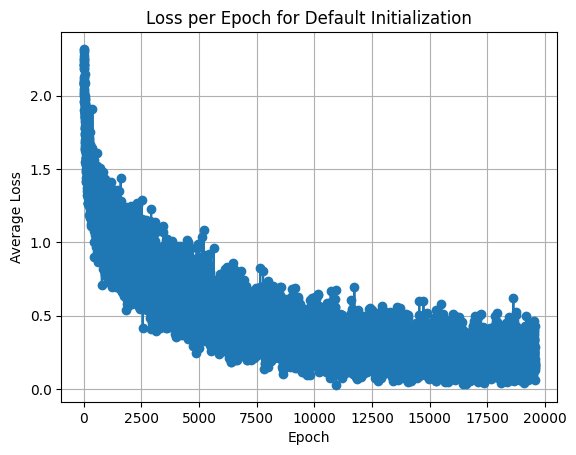

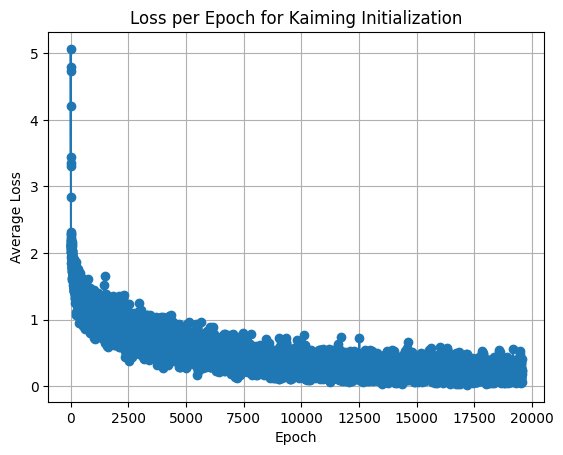

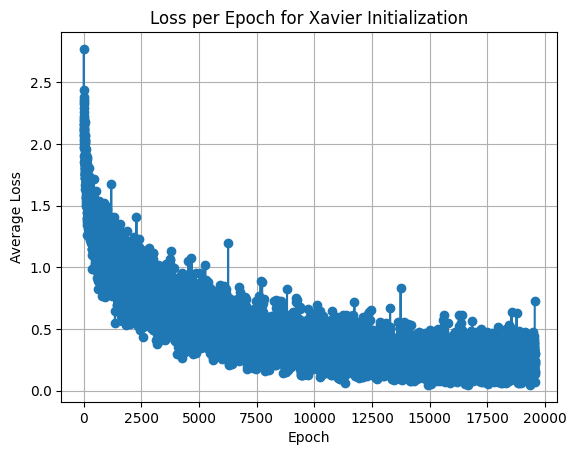

In [ ]:
def plot_loss_curves(loss_logs):
    for method, losses in loss_logs.items():
        if losses:  # Check to make sure there is data to plot
            epochs = range(1, len(losses) + 1)
            plt.plot(epochs, losses, marker='o')
        else:
            print(f"No loss data for {method}.")
        plt.title(f'Loss per Epoch for {method} Initialization')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.grid(True)
        plt.show()


plot_loss_curves(batch_loss_logs)

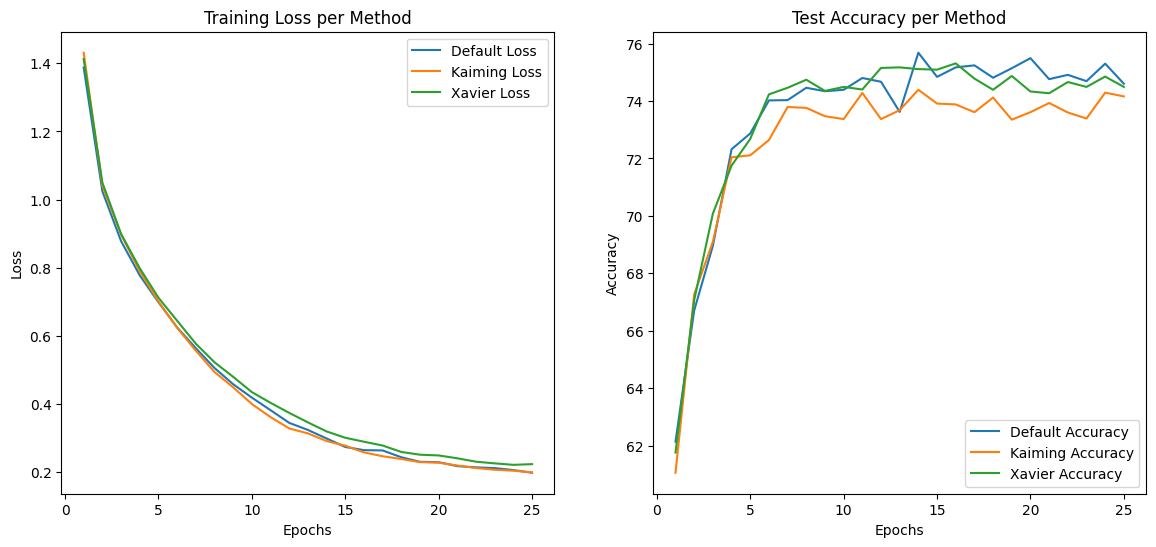

In [ ]:
def plot_learning_curves(loss_logs, accuracy_logs):
    # Create a figure with a specific size
    plt.figure(figsize=(14, 6))

    # Plot training loss per Method
    plt.subplot(1, 2, 1)
    for method, losses in loss_logs.items():
        if losses:  # Check if there is data to plot
            epochs = range(1, len(losses) + 1)
            plt.plot(epochs, losses, label=f'{method} Loss')
        else:
            print(f"No data to plot for {method} losses.")
    plt.title('Training Loss per Method')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracy per Method
    plt.subplot(1, 2, 2)
    for method, accuracies in accuracy_logs.items():
        if accuracies:  # Check if there is data to plot
            epochs = range(1, len(accuracies) + 1)
            plt.plot(epochs, accuracies, label=f'{method} Accuracy')
        else:
            print(f"No data to plot for {method} accuracies.")
    plt.title('Test Accuracy per Method')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plots
    plt.show()

plot_learning_curves(loss_logs, accuracy_logs)


**Default Initialization:** Steady training loss reduction, indicative of consistent learning progression.

**Kaiming Initialization:** Faster initial loss decrease, suggesting quicker convergence; beneficial for expedited training.

**Xavier Initialization:** Similar loss reduction to Kaiming, indicating robustness across initialization strategies.

# Experiment 3: Learning Rate Scheduling

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyperparameters
num_epochs = 25
batch_size = 64
learning_rate = 0.001

In [ ]:
# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [ ]:
# Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Experiment 3: Learning Rate Scheduling
lr_schedule_methods = ["StepLR",
                      "ExponentialLR",
                      "CyclicLR"]

In [ ]:
# Proper step size for CyclicLR
2*len(train_loader)

1564

In [ ]:
print("Experiment 3: Learning Rate Scheduling")

batch_loss_logs = {method: [] for method in lr_schedule_methods}
loss_logs = {method: [] for method in lr_schedule_methods}
accuracy_logs = {method: [] for method in lr_schedule_methods}
convergence_threshold = 0.1  # threshold value
converged_epochs = {method: None for method in lr_schedule_methods}


for method in lr_schedule_methods:
    print(f"Experimenting with {method}")
    model = CNN().to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Learning rate scheduler
    if method == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    elif method == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif method == "CyclicLR":
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr=0.01, step_size_up=1564, step_size_down=1564, mode='triangular', cycle_momentum=False) 

    # Training and evaluation loop
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())
            batch_loss_logs[method].append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Update learning rate
        scheduler.step()

        # Log average loss for this epoch
        average_loss = sum(epoch_losses) / len(epoch_losses)
        loss_logs[method].append(average_loss)

        if average_loss < convergence_threshold and converged_epochs[method] is None:
            converged_epochs[method] = epoch
            print(f"Model with {method} converged at epoch {epoch+1} with loss {average_loss:.4f}")


        # Test the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_accuracy = 100 * correct / total
        accuracy_logs[method].append(epoch_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}] Accuracy: {epoch_accuracy:.2f}%')

    print()

Experiment 3: Learning Rate Scheduling
Experimenting with StepLR
Epoch [1/25], Step [100/782], Loss: 1.7961
Epoch [1/25], Step [200/782], Loss: 1.4687
Epoch [1/25], Step [300/782], Loss: 1.2426
Epoch [1/25], Step [400/782], Loss: 1.4956
Epoch [1/25], Step [500/782], Loss: 1.1331
Epoch [1/25], Step [600/782], Loss: 1.2647
Epoch [1/25], Step [700/782], Loss: 1.0143
Epoch [1/25] Accuracy: 59.84%
Epoch [2/25], Step [100/782], Loss: 0.9193
Epoch [2/25], Step [200/782], Loss: 1.0679
Epoch [2/25], Step [300/782], Loss: 1.1192
Epoch [2/25], Step [400/782], Loss: 1.0660
Epoch [2/25], Step [500/782], Loss: 1.2285
Epoch [2/25], Step [600/782], Loss: 0.9169
Epoch [2/25], Step [700/782], Loss: 0.8848
Epoch [2/25] Accuracy: 67.48%
Epoch [3/25], Step [100/782], Loss: 0.6337
Epoch [3/25], Step [200/782], Loss: 0.8250
Epoch [3/25], Step [300/782], Loss: 0.7775
Epoch [3/25], Step [400/782], Loss: 0.8348
Epoch [3/25], Step [500/782], Loss: 0.7745
Epoch [3/25], Step [600/782], Loss: 1.3524
Epoch [3/25], S

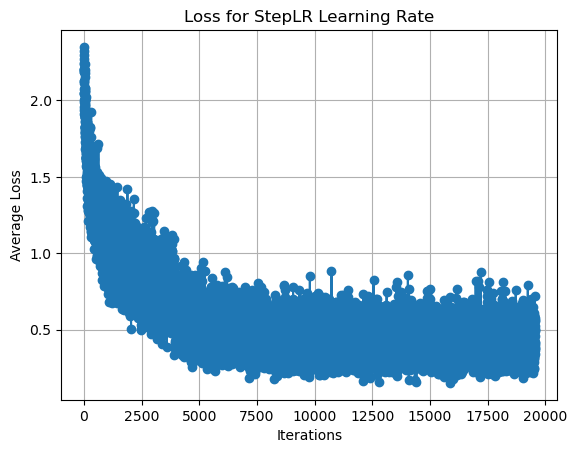

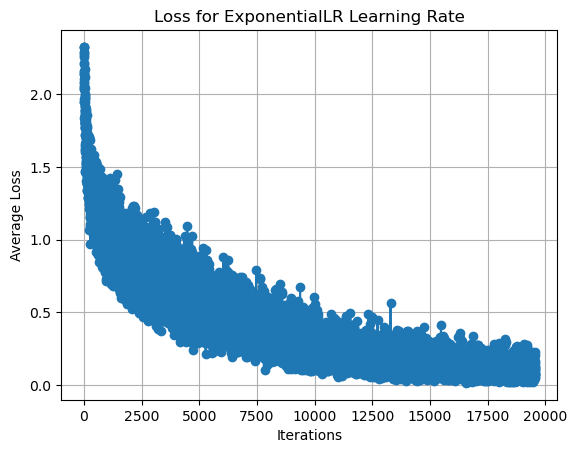

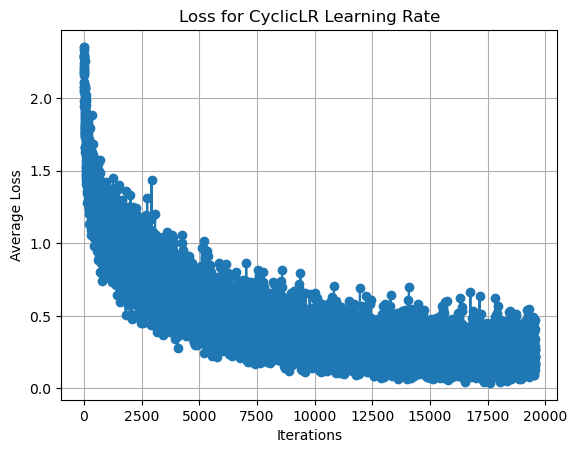

In [ ]:
def plot_loss_curves(loss_logs):
    for method, losses in loss_logs.items():
        if losses:  # Check to make sure there is data to plot
            epochs = range(1, len(losses) + 1)
            plt.plot(epochs, losses, marker='o')
        else:
            print(f"No loss data for {method}.")
        plt.title(f'Loss for {method} Learning Rate')
        plt.xlabel('Iterations')
        plt.ylabel('Average Loss')
        plt.grid(True)
        plt.show()


plot_loss_curves(batch_loss_logs)

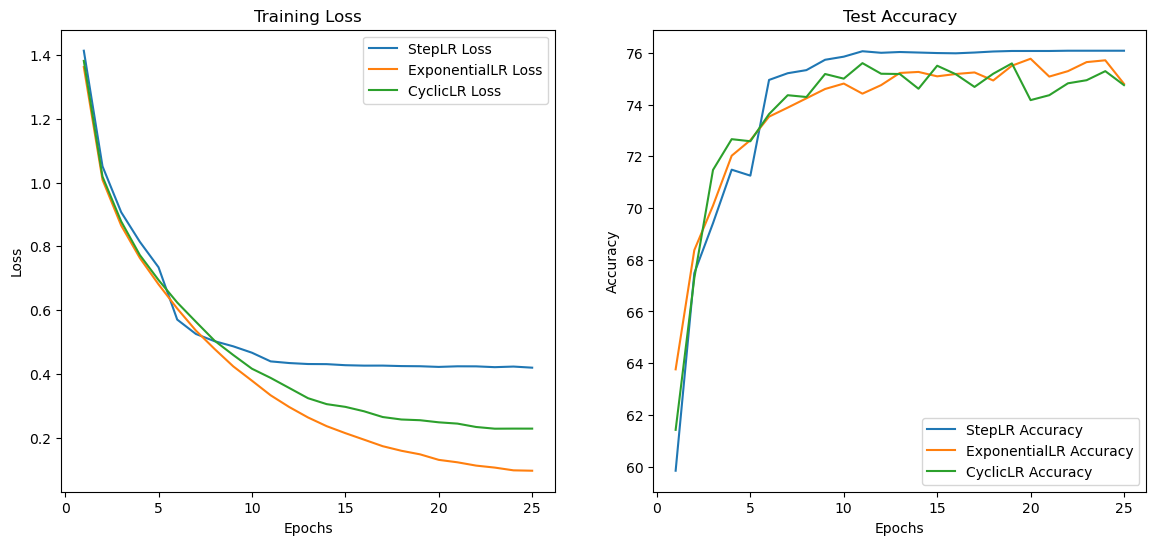

In [ ]:
def plot_learning_curves(loss_logs, accuracy_logs):
    # Create a figure with a specific size
    plt.figure(figsize=(14, 6))

    # Plot training loss per Method
    plt.subplot(1, 2, 1)
    for method, losses in loss_logs.items():
        if losses:  # Check if there is data to plot
            epochs = range(1, len(losses) + 1)
            plt.plot(epochs, losses, label=f'{method} Loss')
        else:
            print(f"No data to plot for {method} losses.")
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracy per Method
    plt.subplot(1, 2, 2)
    for method, accuracies in accuracy_logs.items():
        if accuracies:  # Check if there is data to plot
            epochs = range(1, len(accuracies) + 1)
            plt.plot(epochs, accuracies, label=f'{method} Accuracy')
        else:
            print(f"No data to plot for {method} accuracies.")
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plots
    plt.show()

plot_learning_curves(loss_logs, accuracy_logs)


**StepLR**: Shows gradual and steady loss reduction, conducive to consistent learning.

**ExponentialLR**: Similar downward trend in loss, indicating continuous learning, albeit with a generally higher loss value throughout.

**CyclicLR**: Exhibits fluctuating loss but with overall downward trend, suggesting periodic learning rate resets may help in exploring the loss landscape.

----